In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL.Image as Image
import gym
import random

from gym import Env, spaces
import time


In [4]:
font = cv2.FONT_HERSHEY_COMPLEX_SMALL

In [5]:

class Striker:
    def __init__(self):
        self.x = 0
        self.y = 200
        self.width = 15
        self.height = 60
        self.y_min = 0
        self.y_max = 400
        self.velocity = 5
        self.screen_height = 400

        # now creating icon for it
        self.icon = cv2.imread("paddle.png") / 255.0
        self.icon = cv2.resize(self.icon, (self.width, self.height))
        
        

    def set_position(self, x, y):
        self.x = x
        self.y = y

    def get_position(self):
        return (self.x, self.y)
    
    def move(self,direction):
        if direction == 'up':
            self.y -= self.velocity
        elif direction == 'down':
            self.y += self.velocity
        
        if self.y < 0:
            self.y = 0
        elif self.y + self.height > self.screen_height:
            self.y = self.screen_height - self.height

        self.set_position(self.x, self.y)
             
        

class Ball:
    def __init__(self):
        self.x = 400
        self.y = 200
        self.radius = 10
        self.velocity_x = 3
        self.velocity_y = 3
        self.color = (255, 255, 255)
        self.screen_width = 800
        self.screen_height = 400


    def set_position(self, x, y):
        self.x = x
        self.y = y

    def get_position(self):
        return (self.x, self.y)


    def move(self):
        self.x += self.velocity_x
        self.y += self.velocity_y

        if self.y - self.radius <= 0 or self.y + self.radius >= self.screen_height:
            self.velocity_y = -self.velocity_y
        if self.x - self.radius <= 0 or self.x + self.radius >= self.screen_width:
            self.velocity_x =  -self.velocity_x


        self.set_position(self.x, self.y)


/home/abhay/Projects/Pong/venv/lib64/python3.12/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


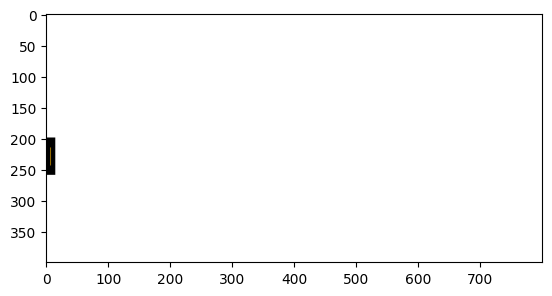

In [12]:
class PongEnvironment(Env):
    
    def __init__(self):
        super(PongEnvironment, self).__init__()

        self.height = 400
        self.width = 800
        
        self.observation_shape = (self.height, self.width, 3)
        self.observation_space = spaces.Box(low = np.zeros(self.observation_shape),
                                            high = np.ones(self.observation_shape),
                                            dtype = np.float16)
        
        # so we have only 2 action [0:left, 1:right]
        self.action_space = spaces.Discrete(2)

        self.canvas = np.ones(self.observation_shape) * 1

        # Defining elements present inside the environment
        self.elements = []
        # e.g -> striker, ball ( distinct elements )

    def draw_elements_on_canvas(self):
        
        self.canvas = np.ones(self.observation_shape) * 1

        for elem in self.elements:
            elem_shape = elem.icon.shape
            x, y = elem.x, elem.y
            self.canvas[y : y + elem_shape[0], x : x + elem_shape[1]] = elem.icon

    def reset(self):
        # episodic return
        self.ep_return = 0

        # Initialize striker object
        self.striker = Striker()
        self.striker.set_position(0, 200)

        # adding to elements
        self.elements = [self.striker]

        self.canvas = np.ones(self.observation_shape) * 1

        # drawing elements on canvas
        self.draw_elements_on_canvas()

        # returning observation
        return self.canvas    


    def step(self):
        pass



env = PongEnvironment()
obs = env.reset()
plt.imshow(obs)

        